In [2]:
from skimage import data as sd
import skimage.color as sc
from skimage.viewer import ImageViewer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

pd.set_option('precision',10)

img = sd.imread('./Both/285826.jpg')
img_hsv = sc.convert_colorspace(img, 'RGB', 'HSV')

viewer = ImageViewer(img_hsv)

img_hsv.shape #(600, 467, 3) height, width, 3 vals for HSV

/Users/noel/anaconda/lib/python3.6/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


(600, 573, 3)

In [3]:
def average_hsv(img_hsv):

    height = len(img_hsv)
    width = len(img_hsv[0])
    pixels = height * width
    sum_hue = 0
    sum_saturation = 0
    sum_value = 0

    for i in range(height):
        for j in range(width):
            sum_hue += img_hsv[i][j][0]
            sum_saturation += img_hsv[i][j][1]
            sum_value += img_hsv[i][j][2]

    avg_hue = sum_hue / pixels
    avg_saturation = sum_saturation / pixels
    avg_value = sum_value / pixels

    return avg_hue, avg_saturation, avg_value
        
        
avg_hue, avg_saturation, avg_value = average_hsv(img_hsv)
avg_hue, avg_saturation, avg_value

(0.098201377925763833, 0.32000107736085603, 0.8899424540042129)

In [ ]:
def hsv_df(img_hsv):
    height = len(img_hsv)
    width = len(img_hsv[0])
    pixels = height * width
    hue = []
    saturation = []
    value = []
    
    for i in range(height):
        for j in range(width):
            hue.append(img_hsv[i][j][0])
            saturation.append(img_hsv[i][j][1])
            value.append(img_hsv[i][j][2])
            
    data = {'H': hue, 'S': saturation, 'V': value}
    hsv_df = pd.DataFrame(data=data)
    
    return hsv_df

df = hsv_df(img_hsv)

df.mean()


In [ ]:
df.std()

In [ ]:
##rgb historgram

fig, ax = plt.subplots()

values, bins = np.histogram(img, bins=np.arange(256))
ax.plot(bins[:-1], values, lw=2, c='k')
ax.set_xlim(xmax=256)
ax.set_title('Histogram', fontsize=24)

In [ ]:
# for 20 bins, find the count of pixels that fall there, probably this should be divided by total pixels such that we have percentages

bins = [0,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00]

pd.cut(df['H'], bins=bins).value_counts()

In [ ]:
from scipy import ndimage

ndimage.measurements.center_of_mass(img_hsv)

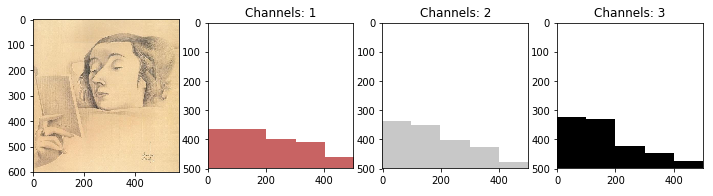

In [4]:
from scipy.cluster.vq import vq, kmeans

def do_cluster(hsv_image, K, channels):
    # gets height, width and the number of channes from the image shape
    h,w,c = hsv_image.shape
    # prepares data for clustering by reshaping the image matrix into a (h*w) x c matrix of pixels
    cluster_data = hsv_image.reshape( (h*w,c) )
    # grabs the initial time
#     t0 = t.time()
    # performs clustering
    codebook, distortion = kmeans(np.array(cluster_data[:,0:channels], dtype=np.float), K)
    # takes the final time
#     t1 = t.time()
#     print "Clusterization took %0.5f seconds" % (t1-t0)
    
    
    # calculates the total amount of pixels
    tot_pixels = h*w
    # generates clusters
    data, dist = vq(cluster_data[:,0:channels], codebook)
    # calculates the number of elements for each cluster
    weights = [len(data[data == i]) for i in range(0,K)]
    
    # creates a 4 column matrix in which the first element is the weight and the other three
    # represent the h, s and v values for each cluster
    color_rank = np.column_stack((weights, codebook))
    # sorts by cluster weight
    color_rank = color_rank[np.argsort(color_rank[:,0])]

    # creates a new blank image
    new_image =  np.array([0,0,255], dtype=np.uint8) * np.ones( (500, 500, 3), dtype=np.uint8)
    img_height = new_image.shape[0]
    img_width  = new_image.shape[1]

    # for each cluster
    for i,c in enumerate(color_rank[::-1]):
        
        # gets the weight of the cluster
        weight = c[0]
        
        # calculates the height and width of the bins
        height = int(weight/float(tot_pixels) *img_height )
        width = round(img_width/len(color_rank))

        # calculates the position of the bin
        x_pos = i*width

        # defines a color so that if less than three channels have been used
        # for clustering, the color has average saturation and luminosity value
        color = np.array( [0,128,200], dtype=np.uint8)
        
        # substitutes the known HSV components in the default color
        for j in range(len(c[1:])):
            color[j] = c[j+1]
        
        # draws the bin to the image
        new_image[ img_height-height:img_height, x_pos:x_pos+width] = [color[0], color[1], color[2]]
        
    # returns the cluster representation
    return new_image

# creates a new figure size 12x10 inches
plt.figure(figsize=(12,10))
# creates a 4-column subplot
plt.subplot(141)
# in the first cell draws the target image
plt.imshow(img)

# calculates clusters for
# * h
# * h and s
# * h, s and v

for i in range(1,4):
    plt.subplot(141 + i)
    plt.title("Channels: %i" % i)
    new_image = do_cluster(img_hsv, 5, i)
    new_image = sc.hsv2rgb(new_image)
    plt.imshow(new_image)
    
plt.show()

/Users/noel/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


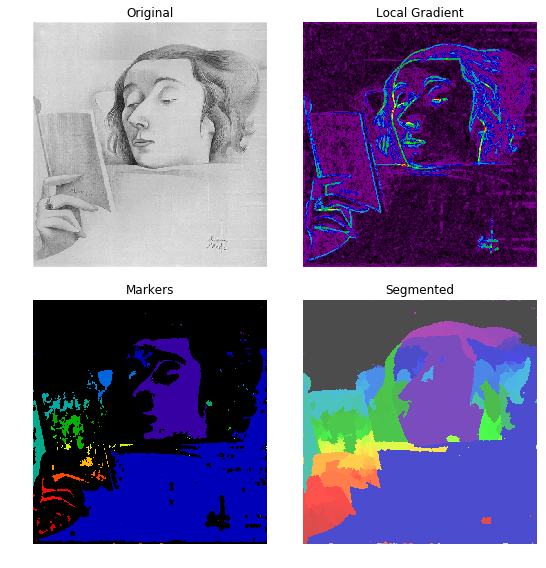

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 24,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [18]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage.morphology import watershed, disk
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte



image = img_as_ubyte(sd.imread('./Both/285826.jpg', as_grey=True))

# denoise image
denoised = rank.median(image, disk(2))

# find continuous region (low gradient -
# where less than 10 for this image) --> markers
# disk(5) is used here to get a more smooth image
markers = rank.gradient(denoised, disk(5)) < 10
markers = ndi.label(markers)[0]

# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(denoised, disk(2))

# process the watershed
labels = watershed(gradient, markers)

# display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.spectral, interpolation='nearest')
ax[1].set_title("Local Gradient")

ax[2].imshow(markers, cmap=plt.cm.spectral, interpolation='nearest')
ax[2].set_title("Markers")

# ax[3].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[3].imshow(labels, cmap=plt.cm.spectral, interpolation='nearest', alpha=.7)
ax[3].set_title("Segmented")

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

labels[:][5]